# Gender Classification

**Dataset**: https://www.kaggle.com/datasets/ashishjangra27/gender-recognition-200k-images-celeba

## Importar dependencias

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Configuración

Ajustamos el formato de la imagen que posteriormente deberá coincidir con la capa de entrada de la CNN

In [4]:
pic_size = (200, 200)
base_path = '../datasets/gender'

## Data Augmentation y Carga de Datos

### Función para Data Augmentation

Generamos nuevas imágenes sintéticas a partir de las imágenes de entrenamiento para evitar el sobreajuste

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

### Cargando datos

In [6]:
train_generator = train_datagen.flow_from_directory(
    f"{base_path}/train",
    target_size=pic_size,
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    f"{base_path}/validation",
    target_size=pic_size,
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    f"{base_path}/test",
    target_size=pic_size,
    batch_size=32,
    class_mode='sparse'
)

Found 16000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


## Arquitectura del modelo

Nuestra red neuronal se compone de tres capas con 32, 64 y 128 filtros, en las cuales se desactivaran aleatoriamente un 20% de las neuronas (dropout) en cada una. Aplicamos una capa intermedia de 1000 neuronas y una softmax como función de activación en la capa de salida

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(200, 200, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.2),
    Conv2D(128, (3, 3), padding='same', activation=tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.2),
    Flatten(),
    Dense(1000, activation=tf.nn.relu),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │    80,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,097,146 (305.55 MB)

 Trainable params: 80,096,698 (305.54 MB)

 Non-trainable params: 448 (1.75 KB)

## Compilación y entrenamiento

Adicionalmente al proceso de entrenamiento añadimos las funciones *early_stopping* y *reduce_lr*

**early_stopping** monitorea la pérdida de validación y para el entrenamiento si esta no mejora después de 5 épocas

**reduce_lr** si detecta pérdida de validación reduce la tasa de aprendizaje al 20% y comprueba si mejora durante 3 épocas

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

/home/pedro/ESESA/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7400 - loss: 11.7869

/home/pedro/ESESA/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step - accuracy: 0.7401 - loss: 11.7713 - val_accuracy: 0.7752 - val_loss: 1.2617 - learning_rate: 0.0010
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.8833 - loss: 0.3096 - val_accuracy: 0.9052 - val_loss: 0.2267 - learning_rate: 0.0010
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 932s 2s/step - accuracy: 0.9081 - loss: 0.2343 - val_accuracy: 0.9370 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 933s 2s/step - accuracy: 0.9219 - loss: 0.1985 - val_accuracy: 0.9380 - val_loss: 0.1496 - learning_rate: 0.0010
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 934s 2s/step - accuracy: 0.9229 - loss: 0.2033 - val_accuracy: 0.9143 - val_loss: 0.2219 - learning_rate: 0.0010
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 931s 2s/step - accuracy: 0.9188 - loss: 0.2370 - val_accuracy: 0.9199 - val_loss: 0.2459 - learning_rate: 0.0010
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 934s 2s/step - accuracy: 0.9218 - loss: 0.1942 - val

## Comportamiento del entrenamiento

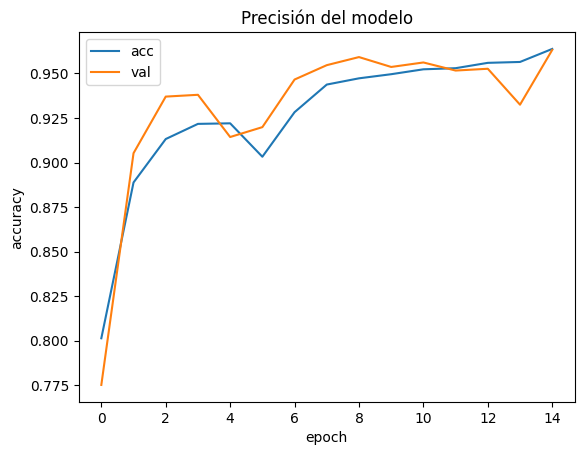

In [10]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val'], loc='upper left')
plt.show()

## Función para predecir una imagen

In [11]:
def predict_image(model, image_path, target_size=pic_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    return prediction

## Predicciones de comprobación

In [12]:
class_labels = ['female', 'male']

In [17]:
def display_and_predict(image_path, model, class_labels):
    try:
        if not model:
            raise ValueError("Model cannot be None")
        if not class_labels or not isinstance(class_labels, (list, np.ndarray)):
            raise ValueError("Invalid class labels")

        from IPython.display import Image, display
        display(Image(image_path))
        
        prediction = predict_image(model, image_path)
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction)
        
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}")
        
        return predicted_class, confidence
        
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

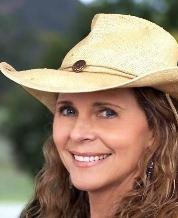

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted class: female
Confidence: 1.00


In [18]:
predicted_class_1, confidence_1 = display_and_predict('../pictures/4.jpg', model, class_labels)

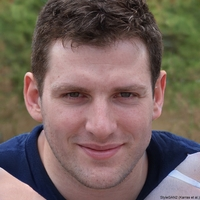

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted class: male
Confidence: 1.00


In [19]:
predicted_class_2, confidence_2 = display_and_predict('../pictures/5.jpeg', model, class_labels)

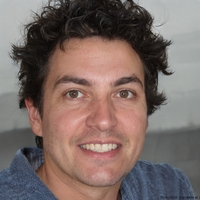

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted class: male
Confidence: 1.00


In [20]:
predicted_class_3, confidence_4 = display_and_predict('../pictures/6.jpeg', model, class_labels)